In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas
import ast
import os
from PIL import Image

In [ ]:
# Get parts list - use indices of each part as "label", for one-hot encoding
parts_list = []
with open('BerendPartsList') as f:
  for line in f:
    word = line[:len(line) - 1] # get rid of '\n
    parts_list.append(int(word))

print(parts_list)

[4153825, 6104154, 6249125, 4210718, 4181135, 623224, 4621545, 4211166, 4121739, 6062574, 4567338, 4153827, 4539099, 306223, 6229071, 654126, 4550325, 4114319, 4165967, 4527943, 300424, 4181144, 6138173, 6177697, 6022023, 6028324, 6151663, 4121967, 4109995, 4211437, 4647553, 6035291, 306201, 4212454, 6073026, 4211201, 300401, 300421, 300821, 4529247, 4118793, 4504369, 6238674, 6069259, 6223631, 6022064, 300121, 300321, 300124, 4211614, 6225539, 300123, 4649749, 4651236, 4639693, 4157124, 4550348, 6244886, 6075079, 6025026, 4529240, 4558957, 4517992, 4548180, 614321, 6003007, 4211511, 4504381, 6252809, 4181134, 4211412, 300423, 4211149, 4650630, 6074890, 4160403, 4655172, 4211221, 4143562, 6075075, 6004938, 365901, 4211054, 4520632, 300323]


In [ ]:
csv_path = '/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/Berend/CSV/labels.csv'
image_path = '/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/Berend/Images'

data = pandas.read_csv(csv_path)
# Convert label col to list of ints of part numbers:
for i in range(len(data["Labels"])):
  label = data["Labels"][i]
  list_row = ast.literal_eval(label)
  data["Labels"][i] = list(map(int, list_row))
# Do same for Color column:
for i in range(len(data["Color"])):
  label = data["Color"][i]
  list_row = ast.literal_eval(label)
  data["Color"][i] = list(map(int, list_row))

In [ ]:
# Let us only deal with the first 10 data points:
data_subset = data[:10]
print(data_subset)

  Name     Light  ...            Color                                Labels
0  B_0  daylight  ...  [130, 130, 130]                             [4650630]
1  B_1  daylight  ...  [130, 130, 130]                             [4650630]
2  B_2  daylight  ...  [130, 130, 130]                             [4650630]
3  B_3  daylight  ...  [130, 130, 130]                    [4650630, 6252809]
4  B_4  daylight  ...  [130, 130, 130]                    [4650630, 6252809]
5  B_5  daylight  ...  [130, 130, 130]                    [4650630, 6252809]
6  B_6  daylight  ...  [130, 130, 130]           [4650630, 6252809, 4211054]
7  B_7  daylight  ...  [130, 130, 130]           [4650630, 6252809, 4211054]
8  B_8  daylight  ...  [130, 130, 130]           [4650630, 6252809, 4211054]
9  B_9  daylight  ...  [130, 130, 130]  [4650630, 6252809, 4211054, 4548180]

[10 rows x 5 columns]


In [ ]:
class BerendDataset(Dataset):
  # For our dataset, let us accept a CSV file as input
  # + a list of parts, for a one-hot encoding.
  # We will also accept a root directory for images. 
  # We also accept transformations to the image
  def __init__(self, csv_path, parts_list, image_root, transforms):
    self.csv_path = csv_path
    self.parts_list = parts_list
    self.image_root = image_root
    data = pandas.read_csv(csv_path)
    # Convert label col to list of ints of part numbers:
    for i in range(len(data["Labels"])):
      label = data["Labels"][i]
      list_row = ast.literal_eval(label)
      int_list = list(map(int, list_row))
      data["Labels"][i] = list(map(lambda x: parts_list.index(x), int_list))

    # Do same for Color column:
    for i in range(len(data["Color"])):
      label = data["Color"][i]
      list_row = ast.literal_eval(label)
      data["Color"][i] = list(map(int, list_row))
    
    self.data = data
    self.transforms = transforms

  def __getitem__(self, idx):
    labels = self.data["Labels"][idx]
    img_path = os.path.join(self.image_root, self.data["Name"][idx] + '.jpg')
    img = Image.open(img_path).convert("RGB")
    if self.transforms is not None:
      img = self.transforms(img)

    return img, labels
  def __len__(self):
        return len(self.data)

In [ ]:
data_transform = transforms.Compose([transforms.ToTensor()])
dataset = BerendDataset(csv_path=csv_path, parts_list=parts_list, image_root=image_path, transforms=data_transform)

In [ ]:
item = dataset[9]

(tensor([[[0.3059, 0.3020, 0.2941,  ..., 0.3765, 0.3725, 0.3608],
         [0.2863, 0.2824, 0.2784,  ..., 0.3647, 0.3647, 0.3608],
         [0.2902, 0.2902, 0.2941,  ..., 0.3569, 0.3686, 0.3725],
         ...,
         [0.4196, 0.4196, 0.4235,  ..., 0.4627, 0.4667, 0.4745],
         [0.4157, 0.4196, 0.4196,  ..., 0.4627, 0.4667, 0.4745],
         [0.4196, 0.4196, 0.4196,  ..., 0.4667, 0.4706, 0.4745]],

        [[0.2824, 0.2784, 0.2706,  ..., 0.3373, 0.3333, 0.3216],
         [0.2627, 0.2588, 0.2549,  ..., 0.3255, 0.3255, 0.3216],
         [0.2667, 0.2667, 0.2706,  ..., 0.3176, 0.3176, 0.3216],
         ...,
         [0.4471, 0.4471, 0.4510,  ..., 0.4471, 0.4510, 0.4588],
         [0.4431, 0.4471, 0.4471,  ..., 0.4471, 0.4510, 0.4588],
         [0.4471, 0.4471, 0.4471,  ..., 0.4510, 0.4549, 0.4588]],

        [[0.1882, 0.1843, 0.1765,  ..., 0.3020, 0.2980, 0.2863],
         [0.1686, 0.1647, 0.1529,  ..., 0.2902, 0.2902, 0.2863],
         [0.1647, 0.1647, 0.1686,  ..., 0.2824, 0.2863, 0

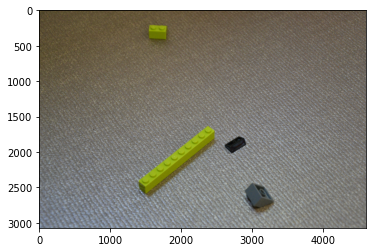

In [ ]:
print(item)
image = item[0]
img = np.transpose(image, [1,2,0])
plt.imshow(img)

In [ ]:
print(len(dataset))

819
